In [1]:
%matplotlib inline
import numpy as np
from scipy.sparse.linalg import LinearOperator, svds, aslinearoperator
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler
from pysgpp import DataMatrix, DataVector, createOperationMultipleEval, Grid
import pysgpp as sg; sg.omp_set_num_threads(4)
from __future__ import division, print_function

import sys, os

sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, to_data_matrix, split
from sgpi.plot import *

In [2]:
grid = Grid.createModLinearGrid(8)
gen = grid.getGenerator()
storage = grid.getStorage()
gen.regular(4)

df = get_dataset('concrete')
train, test = split(df)
X_train, y_train = get_xy(train)
X_test, y_test = get_xy(train)

In [3]:
def eval_op(x, op, size):
    result_vec = DataVector(size)
    x = DataVector(np.array(x).flatten())
    op.mult(x, result_vec)
    return result_vec.array().copy()

def eval_op_transpose(x, op, size):
    result_vec = DataVector(size)  
    x = DataVector(np.array(x).flatten())
    op.multTranspose(x, result_vec)
    return result_vec.array().copy()
  
data_train = to_data_matrix(X_train)
data_test = to_data_matrix(X_test)

num_elem = X_train.shape[0]

op = createOperationMultipleEval(grid, data_train)
matvec = lambda x: eval_op(x, op, num_elem)
rmatvec = lambda x: eval_op_transpose(x, op, grid.getSize())

shape = (num_elem, grid.getSize())
linop = LinearOperator(shape, matvec, rmatvec, dtype='float64')

y_sg = np.matrix(y_train).T
x_sg = np.matrix(np.zeros(grid.getSize())).transpose()

In [5]:
u, s, v = svds(linop, k=grid.getSize() - 1)
#A_sg = np.matrix(((u * s) * np.matrix(v)))

# FISTA

## Proximal operator & splitting

(see proximal algorithms boyd)

$$
f(x) = (1/2)\Vert Ax - b \Vert_2^2, \qquad g(x) = \lambda \Vert x \Vert_1 \\
\nabla f(x) = A^\text{T}(Ax-b) \\
\text{prox}_{\lambda g}(x) = ( x - \lambda)_+ - (-x - \lambda)_+
\\
$$

Note: get_residual calculates $\Vert Ax - b \Vert_2^2$, note the missing $1/2$.
All calculations use the adjusted value $1/2 * \text{ residual}$

In [4]:
def array_to_linop(A):
    matvec_A = lambda x: A*x
    rmatvec_A = lambda x: A.transpose()*x
    linop = LinearOperator(A.shape, matvec_A, rmatvec_A, dtype='float64')
    return linop

def proximal_l1(x, alpha):
    return np.maximum(x - alpha, 0) - np.maximum(-x - alpha, 0)

def gradient(A, x, b):
    if isinstance(A, np.matrix):
        return A.transpose() * (A * x - b)
    elif isinstance(A, LinearOperator):
        return (A.rmatvec(A.matvec(x) - b))
    
def get_stepsize(A):
    if isinstance(A, np.matrix):
        singular_values = svd(A, compute_uv=False)
        max_sval_A = singular_values.max()      
    elif isinstance(A, LinearOperator):
        _, singular_values, _ = svds(A, k=1)
        max_sval_A = singular_values.max()    
    max_eigen_AA_t = max_sval_A * max_sval_A
    return 1.0/(max_eigen_AA_t)


def get_residual(A, x, b):
    if isinstance(A, np.matrix):
        res = A * x - b
    elif isinstance(A, LinearOperator):
        res = A.matvec(x) - b
    res = np.multiply(res, res)
    return res.sum()


def ista(A, x_start, num_it, lambda_reg, b, residuals=None):
    x_k = x_start
    stepsize = get_stepsize(A)
    for i in xrange(1,num_it+1):
        x_k = proximal_l1(x_k - stepsize * gradient(A, x_k, b), lambda_reg * stepsize)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))
        if residuals is not None:
            residuals.append(get_residual(A, x_k, b))    
    return x_k


def fista(A, x_start, num_it, lambda_reg, b, residuals=None):
    stepsize = get_stepsize(A)
    x_k = x_start
    y_k = x_k.copy()
    t_k = 1.0
    for i in xrange(1,num_it+1):
        x_before = x_k.copy()
        x_k = proximal_l1(y_k - stepsize * gradient(A, y_k, b), lambda_reg * stepsize)
        
        t_before = t_k
        t_k = (1 + np.sqrt(1 + 4 * t_before* t_before))/2
        
        y_k = x_k + ((t_before - 1)/(t_k)) * (x_k - x_before)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))
            print(stepsize**(-1))
        if residuals is not None:
            residuals.append(get_residual(A, x_k, b))
    return x_k


def eval_goal(A, x, b, lambda_reg):
    res = 0.5*get_residual(A, x, b)
    regular = lambda_reg * np.abs(x).sum()
    return res + regular


def eval_upper_bound(A, x, y, b, lambda_reg, L_k):
    # FISTA paper eq. 2.5
    f = 0.5 * get_residual(A, y, b)
    g = lambda_reg * np.abs(x).sum()
    gradient_f = gradient(A, y, b)
    x_minus_y = x - y
    x_minus_y_norm = L_k/2 * np.multiply(x_minus_y, x_minus_y).sum()
    return f + np.dot(np.transpose(gradient_f), x_minus_y) + x_minus_y_norm + g
 
    
def ista_line(A, x, lambda_reg, b, L_before):
    i_k = 0
    eta = 2
    while True:
        L_k = eta**i_k * L_before
        stepsize = 1.0/L_k
        prox = proximal_l1(x - stepsize * gradient(A, x, b), lambda_reg * stepsize)
        goal = eval_goal(A, prox, b, lambda_reg)
        upper_bound = eval_upper_bound(A, prox, x, b, lambda_reg, L_k)
        if goal <= upper_bound:
            return L_k
        i_k += 1

        
def ista_back(A, x_start, num_it, lambda_reg, b):
    x_k = x_start
    L_k = 1.1
    for i in xrange(1,num_it+1):
        L_k = ista_line(A, x_k, lambda_reg, b, L_k)
        stepsize = 1.0/L_k
        x_k = proximal_l1(x_k - stepsize * gradient(A, x_k, b), lambda_reg * stepsize)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))
    return x_k   

def fista_back(A, x_start, num_it, lambda_reg, b):
    L_k = 1.1
    x_k = x_start
    y_k = x_k.copy()
    t_k = 1.0
    for i in xrange(1,num_it+1):
        L_k = ista_line(A, y_k, lambda_reg, b, L_k)
        stepsize = 1.0/L_k
        
        x_before = x_k.copy()
        x_k = proximal_l1(y_k - stepsize * gradient(A, y_k, b), lambda_reg * stepsize)
        
        t_before = t_k
        t_k = (1 + np.sqrt(1 + 4 * t_before* t_before))/2
        
        y_k = x_k + ((t_before - 1)/(t_k)) * (x_k - x_before)
        if i % (num_it/10) == 0:
            residual = get_residual(A, x_k, b)
            print("Iteration {}\t with residual of {}".format(i, residual))            
            print(L_k)
    return x_k

In [5]:
A = np.matrix(np.random.rand(1000,800))
x = np.matrix(np.zeros((800,1)))
b = np.matrix(np.random.rand(1000,1))
lambda_reg = 0.0

In [122]:
%%time
x_ista = ista(A, x, 100, lambda_reg, b)

Iteration 10	 with residual of 84.7212461536
Iteration 20	 with residual of 84.1745858257
Iteration 30	 with residual of 83.6358990475
Iteration 40	 with residual of 83.105040569
Iteration 50	 with residual of 82.5818681172
Iteration 60	 with residual of 82.0662423307
Iteration 70	 with residual of 81.5580266958
Iteration 80	 with residual of 81.0570874837
Iteration 90	 with residual of 80.5632936896
Iteration 100	 with residual of 80.0765169728
CPU times: user 337 ms, sys: 0 ns, total: 337 ms
Wall time: 338 ms


In [12]:
%%time
x_ista = fista(A, x, 1000, lambda_reg, b)

Iteration 100	 with residual of 46.7829528994
200282.760341
Iteration 200	 with residual of 30.1986649843
200282.760341
Iteration 300	 with residual of 24.4107517585
200282.760341
Iteration 400	 with residual of 21.4442629477
200282.760341
Iteration 500	 with residual of 19.8115604736
200282.760341
Iteration 600	 with residual of 18.9080449703
200282.760341
Iteration 700	 with residual of 18.4013104754
200282.760341
Iteration 800	 with residual of 18.0964807351
200282.760341
Iteration 900	 with residual of 17.9159519641
200282.760341
Iteration 1000	 with residual of 17.8036651272
200282.760341
CPU times: user 1.03 s, sys: 1.5 ms, total: 1.03 s
Wall time: 1.04 s


In [13]:
x_ista = fista_back(A, x, 1000, lambda_reg, b)

Iteration 100	 with residual of 52.6607120034
288358.4
Iteration 200	 with residual of 33.7294716679
288358.4
Iteration 300	 with residual of 26.7808927351
288358.4
Iteration 400	 with residual of 23.2453306701
288358.4
Iteration 500	 with residual of 21.1127203222
288358.4
Iteration 600	 with residual of 19.8197752078
288358.4
Iteration 700	 with residual of 19.0292618716
288358.4
Iteration 800	 with residual of 18.5453250878
288358.4
Iteration 900	 with residual of 18.233087564
288358.4
Iteration 1000	 with residual of 18.026946066
288358.4


In [32]:
lambda_reg = 1
x_fista = fista(linop,x_sg,1000,lambda_reg, y_sg)

Iteration 100	 with residual of 22062.6013606
25517.0327502
Iteration 200	 with residual of 17959.8733149
25517.0327502
Iteration 300	 with residual of 16540.3440358
25517.0327502
Iteration 400	 with residual of 15852.4087269
25517.0327502
Iteration 500	 with residual of 15413.6684774
25517.0327502
Iteration 600	 with residual of 15108.0281617
25517.0327502
Iteration 700	 with residual of 14876.9053998
25517.0327502
Iteration 800	 with residual of 14695.8552955
25517.0327502
Iteration 900	 with residual of 14562.2420018
25517.0327502
Iteration 1000	 with residual of 14460.3025136
25517.0327502


In [33]:
op_pred = createOperationMultipleEval(grid, data_test)
prediction = DataVector(X_test.shape[0])
op.mult(DataVector(np.array(x_fista).flatten()), prediction)
prediction = prediction.array()
mse = (prediction - y_test)
mse = np.multiply(mse, mse).sum()
mse/(X_test.shape[0])

17.548910817471427

In [37]:
sorted(np.abs(x_fista))

[matrix([[  7.99785578e-08]]),
 matrix([[ 0.04682648]]),
 matrix([[ 0.06332438]]),
 matrix([[ 0.07458382]]),
 matrix([[ 0.10923726]]),
 matrix([[ 0.11423666]]),
 matrix([[ 0.11795676]]),
 matrix([[ 0.12390492]]),
 matrix([[ 0.13182008]]),
 matrix([[ 0.15925942]]),
 matrix([[ 0.1603743]]),
 matrix([[ 0.21038565]]),
 matrix([[ 0.2262606]]),
 matrix([[ 0.26801116]]),
 matrix([[ 0.31244074]]),
 matrix([[ 0.41916663]]),
 matrix([[ 0.43209456]]),
 matrix([[ 0.47624841]]),
 matrix([[ 0.50225141]]),
 matrix([[ 0.50412765]]),
 matrix([[ 0.5239116]]),
 matrix([[ 0.53213848]]),
 matrix([[ 0.56130251]]),
 matrix([[ 0.56421152]]),
 matrix([[ 0.58141469]]),
 matrix([[ 0.58213808]]),
 matrix([[ 0.63871351]]),
 matrix([[ 0.64367587]]),
 matrix([[ 0.70365588]]),
 matrix([[ 0.79376092]]),
 matrix([[ 0.7943563]]),
 matrix([[ 0.868331]]),
 matrix([[ 0.89543174]]),
 matrix([[ 0.91528056]]),
 matrix([[ 0.98183579]]),
 matrix([[ 1.02066131]]),
 matrix([[ 1.05987658]]),
 matrix([[ 1.08925723]]),
 matrix([[ 1.

In [5]:
num_it = 500
lambda_reg = 10e-1
residuals_fista = []
x_fista = fista(linop,x_sg,num_it,lambda_reg, y_sg, residuals_fista)
residuals_ista = []
x_ista = ista(linop,x_sg, num_it, lambda_reg, y_sg, residuals_ista)
mse_fista = np.array(residuals_fista)/(X_test.shape[0])
mse_ista = np.array(residuals_ista)/(X_test.shape[0])

Iteration 50	 with residual of 27785.5803471
96136.6913317
Iteration 100	 with residual of 14463.6845855
96136.6913317
Iteration 150	 with residual of 10283.8999655
96136.6913317
Iteration 200	 with residual of 8258.61707499
96136.6913317
Iteration 250	 with residual of 7237.05623621
96136.6913317
Iteration 300	 with residual of 6545.49135344
96136.6913317
Iteration 350	 with residual of 6008.98378621
96136.6913317
Iteration 400	 with residual of 5596.04225616
96136.6913317
Iteration 450	 with residual of 5265.48505246
96136.6913317
Iteration 500	 with residual of 4989.12261546
96136.6913317
Iteration 50	 with residual of 95796.9896974
Iteration 100	 with residual of 59309.2228593
Iteration 150	 with residual of 46643.8754234
Iteration 200	 with residual of 39919.4897286
Iteration 250	 with residual of 35463.3289817
Iteration 300	 with residual of 32190.7497962
Iteration 350	 with residual of 29656.930779
Iteration 400	 with residual of 27628.1436797
Iteration 450	 with residual of 259

In [6]:
x = range(0, num_it)

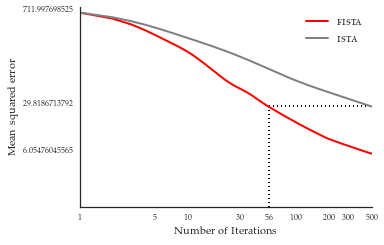

In [16]:
best_ista = mse_ista[-1]
reached_by_fista = np.where(mse_fista < best_ista)[0][0]
worst_mse = np.maximum(mse_ista[0], mse_fista[0])
best_mse = np.minimum(mse_ista[-1], mse_fista[-1])

fig, ax = plt.subplots()
ax.loglog(x, mse_fista, c='red', linewidth=2)
ax.loglog(x, mse_ista, c='gray', linewidth=2)
ax.hlines(best_ista, reached_by_fista, num_it, linestyles='dotted', linewidth=2)
ax.vlines(reached_by_fista, best_ista, ax.get_ylim()[0], linestyles='dotted', linewidth=2)
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Mean squared error")
ax.legend([r"\textsc{fista}", r"\textsc{ista}"])
ax.set_ylim(0, worst_mse)
ax.set_xlim(1, num_it)
x_ticks = sorted([1, 5, 10, 30, reached_by_fista, 100, 200, 300, 500])
ax.set_xticks(x_ticks)
x_labels = ["{}".format(i) for i in x_ticks]
ax.set_xticklabels(x_labels)

y_ticks = [best_mse, best_ista, max(mse_ista[1], mse_fista[1])]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, va='baseline')

sns.despine(fig, ax)
fig.subplots_adjust(left=0.2)
fig.savefig('../writing/thesis/figures/fista.pdf')